Copy rights @Cheng Tang chengtang48@gmail.com

## Plan for numerical simulations

- low-rank data generation: high dimensional, from a subset of coordinates (these are eigenvectors)
- krasulina implementation (done)
- TODO:
    - investigate the effect of dimension and rank
    - investigate perturbed version (optional)
    - compare to Ohad Shamir's SVRG variant of Oja's method (optional)
- Simulation on real data (candidates: MNIST, CCAT?)


# pseodo-code for generalized krasulina
``` 
Input params: init_weights (W^0) (k by d), learning rate schedule (constant and inverse-time), max_iter (T)
While t <= T
 W^{t+1} = W^t + \eta^t W^t x (x - (W^t)^TW^tx)^T
 equivalent to: W^{t+1} = W^t + \eta^t (W^t x x^T - x^T(W^t)^TW^t)
 The step above is equivalent to one SGD update (given that W^t is row orthonormalized) on the objective:
 
 row orthonormalize W^{t+1}
```

In [23]:
import tensorflow as tf
import numpy as np
import math

/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [24]:
np.__config__.show()

mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/include']
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    

In [25]:
# data generators: data should be centered and dispersed around the subspace spanned by gt

def get_train_data(n_train, groundtruth=None):
    """
    gt: d-dimensional vec (non-increasing entries): 
    nonzero at coordinates corresponding to eigenvectors, and the value corresponds eigenvalue
    example: [1,1,0,0,0]
    return: np array train data
    """
    if not groundtruth:
        print("The data generator without groundtruth is not implemented!")
        return
    else:
        train_data = None
        d = len(groundtruth)
        for _ in range(n_train):
            x = np.zeros([1, d])
            for i in range(d):
                if groundtruth[i] > 0 :
                    x[:, i] = np.random.normal(0, groundtruth[i]**0.5)
                else:
                    break
            if train_data is None:
                train_data = x
            else:
                train_data = np.concatenate((train_data, x), axis=0)  
            #print(train_data.shape)
    return train_data

In [26]:
#train_data = get_train_data(5000, groundtruth=[1,1,0])

In [27]:
import time

In [28]:
# test get_train_data
# for i in range(2):
#     ax_mean = np.mean(train_data[:, i])
#     ax_var = np.var(train_data[:, i])
#     print(f"axis {i} mean {ax_mean}")
#     print(f"axis {i} var {ax_var}")

In [34]:
class KrasulinaPCA(object):
    
    def __init__(self, init_weights, train_data, groundtruth=None,
                 learning_rate=[None, 0.0001], mini_batch_size=1, max_iter=100, sampling=False, log_freq=100):
        
        self._init_weights = init_weights
        #self._weights = tf.Variable(init_weights, dtype=tf.float64)
        self._train_data = train_data
        self._train_data_size = train_data.shape
        #assert learning_rate[0] is None, "Decaying learning rate not implemented yet!"
        self._learning_rate = learning_rate
        #self._minibatch_iter = 0
        #assert groundtruth, "training with real data is not implemented yet!"
        self._groundtruth = groundtruth
        self._k, self._d = init_weights.shape[0], init_weights.shape[1]
        self._mbsize = mini_batch_size
        self._T = max_iter
        self._sampling = sampling
        self._log_freq = log_freq
        self._global_step = 0
        self._train_mse_log = list()
    
    def _update_eta(self):
        if self._learning_rate[0] is None:
            self._eta = self._learning_rate[1]
        else:
            self._eta = self._learning_rate[0] / math.log(self._global_step + self._learning_rate[1])
    
    def _update_global_step(self):
        self._global_step += 1
        
    def _train(self):
        # create train log for objective loss (mse)
        self._train_mse_log.append(eval_mse_loss(self._train_data, self._init_weights))
        #if self._groundtruth:
            # create another log for groundtruth metric 
        self._groundtruth_eval_log = list()
        self._groundtruth_eval_log.append(eval_with_groundtruth(self._groundtruth, self._init_weights))
        print(f"The initial mse: {self._train_mse_log[0]}")
        print(f"The initial loss: {self._groundtruth_eval_log[0]}")
       
        mb_iter = 0
        self._epoch = 0
        weights = self._init_weights.copy() 
        ## start training      
        for t in range(1, self._T+1):
            Ts = time.time()
            epoch_old = self._epoch
            if not self._sampling:
                # get mini batches by iterating over the dataset
                mini_batch, mb_iter = self._get_mini_batch(mb_iter, t)
            else:
                # sampling u.a.r.
                mini_batch = self._get_mini_batch_from_sampling()
            self._update_global_step()
            self._update_eta()
            # run optimization
            # W^{t+1} = W^t + eta^t (W^t x x^T - W^t x x^T(W^t)^TW^t)
            ts = time.time()
            emp_cov = 1.0/self._mbsize * np.matmul(mini_batch.T, mini_batch)
            te = time.time()
            #print("Computing empirical matrix takes {}".format(te-ts))
            ts = time.time()
            A = np.dot(weights, emp_cov) # k by d and d by d
            te = time.time()
            #print("Computing A matrix takes {}".format(te-ts))
            ts = time.time()
            #B = np.matmul(weights.T, weights) # d by k and k by d
            #print(weights.flags)
            #B = np.dot(weights.T, weights)
            B = np.dot(A, weights.T)
            te = time.time()
            #print("Computing B matrix takes {}".format(te-ts))
            ts = time.time()
            #C = np.matmul(A, B)
            C = np.dot(B, weights)
            te = time.time()
            #print("Computing C matrix takes {}".format(te-ts))
            weights = weights + self._eta * (A - C)
            # orthonormalization
            ts = time.time()
            weights = row_orthonormalization(weights)
            te = time.time()
            #print("Row orthonormalization takes {}".format(te-ts))
            """
            TODO: check that rows of _weights are orthonormal (difference with eye should be small)
            """ 
            if not self._sampling and epoch_old < self._epoch:
                self._add_to_train_logs(weights)
            elif self._sampling and (t % self._log_freq == 0):
                self._add_to_train_logs(weights)
            
            Te = time.time()
            #print("One iteration takes {}".format(Te-Ts))
        self.final_weights_ = weights.copy()

    
    def _reset_train_logs(self):
        self._train_log = list()
        self._groundtruth_eval_log = list()
    
    def _add_to_train_logs(self, weights):
        self._train_mse_log.append(eval_mse_loss(self._train_data, weights))
        self._groundtruth_eval_log.append(eval_with_groundtruth(self._groundtruth, weights))
        print(f"The loss at the {self._epoch}-th epoch is {self._groundtruth_eval_log[-1]}")
        
    
    
    def _get_mini_batch(self, mb_iter, t):
        if mb_iter + self._mbsize < len(self._train_data):
            mini_batch = self._train_data[mb_iter : mb_iter+self._mbsize, :]
            mb_iter_new = mb_iter + self._mbsize
        else:
            self._epoch += 1
            print(f"Finished training {self._epoch}-th epoch with total {t} iterations")
            mb_iter_new = (mb_iter + self._mbsize) % (len(self._train_data)-1) - 1
            mini_batch_1 = self._train_data[mb_iter :, :]
            mini_batch_2 = self._train_data[: mb_iter_new, :]
            if mini_batch_2.size > 0:
                mini_batch = mini_batch_1
            else:
                mini_batch = np.concatenate((mini_batch_1, mini_batch_2), axis=0)
        return mini_batch, mb_iter_new
    
    def _get_mini_batch_from_sampling(self):
        rand_idx = np.random.randint(self._train_data_size[0], size=self._mbsize)
        return self._train_data[rand_idx,:]
    


def row_orthonormalization(weights):
    """
    Description: implements Gram-schmidt on rows of the tf weights matrix
    Input: weights as a tf variable: k by d (k <= d)
    Return: orthonormalize operation in tf graph
    """
    assert weights.shape[0] <= weights.shape[1], "k cannot exceed d!"
    # add batch dimension for matmul
    #print(weights[0,:].shape)
    ortho_weights = np.expand_dims(weights[0,:]/np.linalg.norm(weights[0,:]),0)
    #print(weights[0:10])
    #ortho_weights = weights[0,:]/np.linalg.norm(weights[0,:])
    #print(ortho_weights.shape)
    for i in range(1, weights.shape[0]):
        v = weights[i,:]
        #print(v.shape)
        # add batch dimension for matmul
        v = np.expand_dims(v, 0) 
        #r = v - np.matmul(np.matmul(v, ortho_weights.T), ortho_weights)
        #print(np.squeeze(np.matmul(v, ortho_weights.T)))
        r = v - np.dot(np.squeeze(np.matmul(v, ortho_weights.T)), ortho_weights)
        ortho_weights = np.concatenate([ortho_weights, r/np.linalg.norm(r)], axis=0)
    return ortho_weights


def eval_with_groundtruth(groundtruth, weights):
    """
    Input: 
        groundtruth, list in the form [2, 1.4, 1, 0, 0]
        weights, np array, shape k by d (row-orthonormal)
    Return:
        tr(U(I-P)): U-projection matrix of eigenvectors, 
                    P: projection matrix of weights
    """
    #eigenvecs = get_eigenvecs(groundtruth)
    eigenvecs = groundtruth.copy()
    U = np.matmul(eigenvecs.T, eigenvecs)
    P = np.matmul(weights.T, weights)
    I = np.eye(weights.shape[1])
    
    return np.trace(np.matmul(U, I-P))


def get_eigenvecs(groundtruth):
    """
    Input: groundtruth in the form of list [1,1,0]
    Return: np array, eigenvecs: k by d
    """
    d = len(groundtruth)
    eigenvecs = None
    for dim in range(d):
        if groundtruth[dim] > 0:
            eigenvec = np.zeros([1, d])
            eigenvec[:, dim] = 1.0
            if eigenvecs is None:
                eigenvecs = eigenvec
            else:
                eigenvecs = np.concatenate((eigenvecs, eigenvec), axis=0)
        else:
            break
    return eigenvecs


def eval_mse_loss(batch_data, _weights):
    """
    Input: np array, batch_data: n by d, 
           np array, weights: k by d
    """
    projection = np.matmul(batch_data, _weights.T)
    xhat = np.matmul(projection, _weights)
    #print(xhat.shape)
    return np.sum(np.square(batch_data-xhat))


def check_orthonormality(weights):
    """
    TODO: Check that rows of weights are nearly orthonormal
    """
    pass
        
def get_default_learning_rate(X):
    rbar = np.linalg.norm(X, ord='fro')
    return 1/rbar * (len(X) ** 0.5)
    
    

In [30]:
## initializers

def get_random_orthogonal_initializer(k, d, gain=1, seed=None):
    tf.reset_default_graph()
    init_fn = tf.orthogonal_initializer(gain, seed, dtype=tf.float64)
    init_weights = tf.get_variable('init_weights', initializer=init_fn, shape=[k, d])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())   
        _init_weights = sess.run([init_weights])[0]
    return _init_weights

In [ ]:
k=2
d=100
gt = [0] * d
for i in range(k):
    gt[i] = (k - i)**1
_init_weights = get_random_orthogonal_initializer(k, d)
n_train = 5000
eigenvecs = get_eigenvecs(gt)
train_data = get_train_data(n_train, groundtruth=gt)

In [ ]:
_init_weights

In [ ]:
T = 8*n_train
lr = (None, 0.01) 
#lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, train_data, groundtruth=eigenvecs, learning_rate=lr, max_iter=T)

In [ ]:
algo._train()

In [ ]:
print(algo._train_mse_log[0], algo._train_mse_log[-1])

In [ ]:
print(algo._groundtruth_eval_log[0], algo._groundtruth_eval_log[-1])

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
import math

iterations = range(T)
#log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._groundtruth_eval_log]

In [ ]:
epoch = 0
gt_eval_epoch_wise = list()
epoch_iters = list()
for t, e in enumerate(algo._groundtruth_eval_log):
    if t % n_train == 0:
        epoch += 1
        gt_eval_epoch_wise.append(e)
        epoch_iters.append(epoch)
    

In [ ]:
#plt.plot(iterations, log_error)
plt.plot(iterations, log_error)

In [ ]:
## train all variations
count = 1
n_train = 5000
algo_meta_dict = {}
for k in [1, 10]:
    for d in [10, 100, 500]:
        algo_list = []
        for eta in [(None, 0.0001/k), (0.001/k, 10)]:
            gt = [0] * d
            for i in range(k):
                gt[i] = (k-i) 
            _init_weights = get_random_orthogonal_initializer(k, d)
            print(f"Runing the {count}-th experiment")
            count += 1
            eigenvecs = get_eigenvecs(gt)
            train_data = get_train_data(n_train, groundtruth=gt)
            T = 8*n_train
            algo_list.append(KrasulinaPCA(_init_weights, train_data, groundtruth=eigenvecs, learning_rate=eta, max_iter=T))
            algo_list[-1]._train()
            print("Initial and final loss")
            print(algo_list[-1]._groundtruth_eval_log[0], algo_list[-1]._groundtruth_eval_log[-1])
        key = (k, d)
        algo_meta_dict[key] = algo_list
            

In [ ]:
algo_meta_dict.keys()

In [ ]:
import json

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
for k, d in algo_meta_dict.keys():
    for idx in [0, 1]:
        algo_meta_dict[(k, d)][idx]._groundtruth_eval_log

In [ ]:
## Plot on all
label_list = [r"$\eta=10^{-4}/k$", r"$\eta^t = \frac{10^{-3}}{k(t+10)}$"]

def get_log(k, d, idx, algo_dict):
    return algo_dict[(k, d)][idx]._groundtruth_eval_log


def plotting(k, d):
    fig=plt.figure()
    for idx in [0, 1]:
        log = get_log(k, d, idx, algo_meta_dict)
        epoch = 0
        gt_eval_epoch_wise = list()
        epoch_iters = list()
        for t, e in enumerate(log):
            if t % n_train == 0:
                epoch += 1
                gt_eval_epoch_wise.append(e)
                epoch_iters.append(epoch)
        #
        #log_epoch_iters = [math.log(t_e) for t_e in epoch_iters]
        log_gt_eval_epoch_wise = [math.log(e) if e > 0 else math.log(e+1) for e in gt_eval_epoch_wise]
        if idx == 1:
            #lr_params = (0.001/k, 10)
            #lr = r"$\frac{0.001}{k(t+10)}$" 
            plt.plot(epoch_iters, log_gt_eval_epoch_wise, '--', label=label_list[idx])
        else:
            #lr = r"\frac{0.0001}{k}"
            plt.plot(epoch_iters, log_gt_eval_epoch_wise, label=label_list[idx])
    plt.legend()
    #plt.title(f"k={k}, d={d}")
    plt.xlabel('epochs')
    plt.ylabel(r'log $\Delta^t$')
    fig.savefig(f"k-{k}-d-{d}.png")

for k, d in algo_meta_dict.keys():
    plotting(k,d)
    


In [ ]:
!zip figs.zip pre/*

In [ ]:
import math

iterations = range(T)
log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._groundtruth_eval_log]
#const = 100
#theo = [-t + const for t in iterations]

In [ ]:
plt.plot(iterations, log_error)
#plt.plot(iterations, theo)
#plt.plot(log_iterations, log_error)
#plt.plot(iterations, algo._groundtruth_eval_log)
#plt.plot(iterations, algo._train_mse_log)

In [ ]:
log_epoch_iters = [math.log(t_e) for t_e in epoch_iters]
log_gt_eval_epoch_wise = [math.log(e) for e in gt_eval_epoch_wise]
plt.plot(epoch_iters, log_gt_eval_epoch_wise)

In [ ]:
test_arr = [1,2,3]
#print(test_arr[:0])
if test_arr[:1]:
    print("not null")

In [ ]:
x = list(range(1000))
y = [1/float(t+1) for t in x]
y1 = [2**(-t) for t in x]
log_y = [math.log(e) for e in y]
log_y1 = [math.log(e) for e in y1]
plt.plot(x, log_y1)

### MNIST

In [1]:
!pip install python-mnist

In [2]:
!git clone https://github.com/sorki/python-mnist

fatal: destination path 'python-mnist' already exists and is not an empty directory.


In [3]:
from mnist import MNIST
from sklearn.decomposition import PCA

In [4]:
!brew install wget

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
azure-storage-cpp   i386-elf-binutils   mesa                sourcedocs
fluxctl             i386-elf-gcc        ruby@2.4
==> Updated Formulae
gdbm ✔                                   jenkins
pyenv ✔                                  jhipster
ruby ✔                                   jq
activemq                                 kakoune
advancemame                              khal
agda                                     kobalt
aha                                      kotlin
algernon                                 kubernetes-cli
amazon-ecs-cli                           kustomize
ammonite-repl                            lastpass-cli
amqp-cpp                                 latexdiff
annie                                    lean-cli
ansible-cmdb                             lego
apache-flink                             libgit2
app-engine-java                          libgit2-glib
ark               

In [5]:
%%bash
cd python-mnist
./get_data.sh

data directory already present, exiting


In [6]:
mndata = MNIST('python-mnist/data')
images, labels = mndata.load_training()

In [17]:
import numpy as np

images_array = np.array([np.array(data_pt) for data_pt in images[:5000]])
n_samples, n_features = images_array.shape
images_centered = images_array - images_array.mean(axis=0)
images_centered -= images_centered.mean(axis=1).reshape(n_samples, -1)

In [18]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.8, svd_solver='full')

In [21]:
pca.fit(images_centered)

pca.components_

array([[-1.32771944e-02, -1.32771944e-02, -1.32771944e-02, ...,
        -1.32771944e-02, -1.32771944e-02, -1.32771944e-02],
       [-3.66728513e-03, -3.66728513e-03, -3.66728513e-03, ...,
        -3.66728513e-03, -3.66728513e-03, -3.66728513e-03],
       [-1.82539045e-03, -1.82539045e-03, -1.82539045e-03, ...,
        -1.82539045e-03, -1.82539045e-03, -1.82539045e-03],
       ...,
       [-1.88579037e-03, -1.88579037e-03, -1.88579037e-03, ...,
        -1.88579037e-03, -1.88579037e-03, -1.88579037e-03],
       [ 1.03690102e-03,  1.03690102e-03,  1.03690102e-03, ...,
         1.03690102e-03,  1.03690102e-03,  1.03690102e-03],
       [-4.96757936e-05, -4.96757936e-05, -4.96757936e-05, ...,
        -4.96757936e-05, -4.96757936e-05, -4.96757936e-05]])

In [40]:
##
k = 44
d = 784
_init_weights = get_random_orthogonal_initializer(k, d)

T = 1*n_samples
lr = (None, 0.01) 
#lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, images_centered, 
                    groundtruth=pca.components_, 
                    learning_rate=lr, max_iter=T)

In [41]:
algo._train()

The initial mse: 15694642079.037952
The initial loss: 41.551983717851925
Finished training 1-th epoch with total 5000 iterations
The loss at the 1-th epoch is 27.74256386463691


In [42]:
#eval_mse_loss(images_centered, algo.final_weights_)
eval_mse_loss(images_centered, pca.components_)

3279955799.556534

In [ ]:
print(algo._train_mse_log[0], algo._train_mse_log[-1])
print(algo._groundtruth_eval_log[0], algo._groundtruth_eval_log[-1])

In [ ]:
epoch = 0
gt_eval_epoch_wise = list()
epoch_iters = list()
for t, e in enumerate(algo._groundtruth_eval_log):
    if t % n_train == 0:
        epoch += 1
        gt_eval_epoch_wise.append(e)
        epoch_iters.append(epoch)

In [ ]:
iterations = range(T)
log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._groundtruth_eval_log]
plt.plot(iterations, log_error)
#plt.plot(log_iterations, log_error)

In [ ]:
algo._groundtruth_eval_log

### Faces low-rank dataset

In [44]:
from numpy.random import RandomState
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


In [45]:
len(faces_centered)

400

In [46]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.8, svd_solver='full')

In [47]:
pca.fit(faces_centered)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [48]:
pca.n_components_

37

In [49]:
pca.components_.shape

(37, 4096)

In [59]:
##
k = 37
d = 4096
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(faces_centered)
T = 10*n_train
#lr = (None, get_default_learning_rate(faces_centered))
print(get_default_learning_rate(faces_centered))
lr = (None, 0.005) 
#lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, faces_centered, groundtruth=pca.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T)

0.12694351753405397


In [60]:
algo._train()

The initial mse: 24576.25390625
The initial loss: 36.642260807775756
Finished training 1-th epoch with total 400 iterations
The loss at the 1-th epoch is 27.219671664948155
Finished training 2-th epoch with total 800 iterations
The loss at the 2-th epoch is 20.173153476026574
Finished training 3-th epoch with total 1200 iterations
The loss at the 3-th epoch is 15.169161347522667
Finished training 4-th epoch with total 1600 iterations
The loss at the 4-th epoch is 11.481737211239928
Finished training 5-th epoch with total 2000 iterations
The loss at the 5-th epoch is 8.70158401385547
Finished training 6-th epoch with total 2400 iterations
The loss at the 6-th epoch is 6.70419849564003
Finished training 7-th epoch with total 2800 iterations
The loss at the 7-th epoch is 5.2860849857342345
Finished training 8-th epoch with total 3200 iterations
The loss at the 8-th epoch is 4.319220893847163
Finished training 9-th epoch with total 3600 iterations
The loss at the 9-th epoch is 3.6960101219

In [61]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

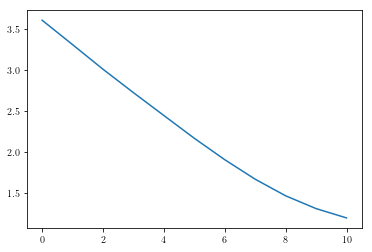

In [62]:
eps = 1e-6
log_error = [math.log(y) if y > 0 else math.log(y+eps) for y in algo._groundtruth_eval_log]
plt.plot(range(11), log_error)

In [ ]:
algo._groundtruth_eval_log[-1]

## 20 Newsgroup

In [9]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

newsgroups_train = fetch_20newsgroups(subset='train')

In [10]:
print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [11]:
print(newsgroups_train.filenames[0])
print(newsgroups_train.filenames.shape)
print(newsgroups_train.target.shape)

/Users/tcheng/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/102994
(11314,)
(11314,)


In [ ]:
categories = ['comp.os.ms-windows.misc', 'rec.sport.baseball', 
              'talk.politics.mideast', 'rec.motorcycles', 'soc.religion.christian']
newsgroups_train_subcat = fetch_20newsgroups(subset='train', categories=categories)

In [ ]:
#newsgroups_train_subcat.target.shape

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=True, max_features=3000)

In [14]:
data_vecs = vectorizer.fit_transform(newsgroups_train.data)

In [15]:
n_samples, n_dim = data_vecs.shape
print(n_samples, n_dim)

11314 3000


In [16]:
# global centering
data_vecs_centered = data_vecs - data_vecs.mean(axis=0)

# local centering
data_vecs_centered -= data_vecs_centered.mean(axis=1).reshape(n_samples, -1)

In [17]:
pca2 = PCA(n_components=0.8, svd_solver='full')
pca2.fit(data_vecs_centered)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [18]:
pca2.n_components_

1134

In [19]:
data_vecs_centered.shape

(11314, 3000)

In [34]:
##
k = 1134
d = 3000
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(data_vecs_centered)
T = int(10*n_train*0.005)
log_freq = int(T*0.2)
print(f"Total number of iterations: {T}; log frequency: {log_freq}")
#lr = (None, get_default_learning_rate(faces_centered))
#print(get_default_learning_rate(data_vecs_centered))
#lr = (None, 0.005) 
#lr = (None, 0.01)
#lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, data_vecs_centered, groundtruth=pca2.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T, sampling=True, log_freq=log_freq)

Total number of iterations: 565; log frequency: 113


In [35]:
algo._train()

The initial mse: 6282.574316331447
The initial loss: 706.0451081299427
The loss at the 0-th epoch is 705.8471278820512
The loss at the 0-th epoch is 705.6509098778461
The loss at the 0-th epoch is 705.4467747724991
The loss at the 0-th epoch is 705.2439521136184
The loss at the 0-th epoch is 705.0393827014783


In [39]:
len(algo._groundtruth_eval_log)

6

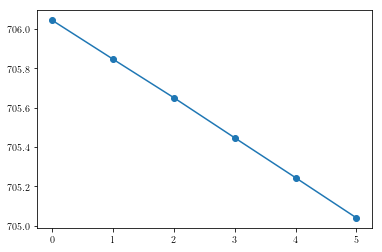

In [43]:
eps = 1e-6
log_error = [math.log(y) if y > 0 else math.log(y+eps) for y in algo._groundtruth_eval_log]
#plt.plot(range(6), log_error)
plt.plot(range(6), algo._groundtruth_eval_log, 'o-')

## Vgg Dataset

script adapted from <https://github.com/cmusatyalab/openface/blob/master/data/vgg/download-and-align.py>

In [23]:
!rm -r aligned

In [24]:
!python preprocess.py

Extracting images of Aamir_Khan
Aamir_Khan has 492 images
Extracting images of Aaron_Staton
Aaron_Staton has 590 images
Extracting images of Aaron_Tveit
Aaron_Tveit has 654 images
Extracting images of Aaron_Yoo
Aaron_Yoo has 657 images
Extracting images of Abbie_Cornish
Abbie_Cornish has 599 images
Extracting images of Abel_Ferrara
Abel_Ferrara has 579 images
Extracting images of Abigail_Breslin
Abigail_Breslin has 615 images
Extracting images of Abigail_Klein
Abigail_Klein has 517 images
Extracting images of Abigail_Spencer
Abigail_Spencer has 651 images
Extracting images of Abraham_Benrubi
Abraham_Benrubi has 568 images
Extracting images of Adam_Baldwin
Adam_Baldwin has 573 images
Extracting images of Adam_Beach
Adam_Beach has 588 images
Extracting images of Adam_Brody
Adam_Brody has 620 images
Extracting images of Adam_Buxton
Adam_Buxton has 507 images
Extracting images of Adam_Copeland
Adam_Copeland has 615 images
Extracting images of Adam_Driver
Adam_Driver has 540 images
Extracti

('raw/Aaron_Yoo./b4ac9475e6a1d48', 'Aaron_Yoo', 'http://www3.pictures.gi.zimbio.com/Rocket%252520Science%2525202007%252520Sundance%252520Portrait%252520Session%2525202qnrvMZ_Gyfl.jpg', (202, 40, 274, 113))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Aaron_Yoo./b782eb742ec58e1', 'Aaron_Yoo', 'http://static.tvgcdn.net/MediaBin/Galleries/Shows/S_Z/Ti_Tp/Tomorrow_People/season1/tomorrow-people-99.jpg', (99, 79, 189, 169))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Aamir_Khan./12258831.cms', 'Aamir_Khan', 'http://www.india-forums.com/tellybuzz/images/uploads/5E4_aamir-khan.jpg', (239, 50, 328, 139))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/op

('raw/Aaron_Staton./6a00d8341c9cc153ef0154337f4331970c-800wi', 'Aaron_Staton', 'http://www.brandish.tv/assets_c/2009/02/wenn5199155-thumb-430x644-75558.jpg', (193, 113, 336, 256))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Aamir_Khan./18219647.cms', 'Aamir_Khan', 'http://cdn2.business2community.com/wp-content/uploads/2014/03/Aamir_Khan_Facebook.png', (256, 85, 448, 277))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abbie_Cornish./320?cb=20130331182802', 'Abbie_Cornish', 'http://1.bp.blogspot.com/_-_DtO2esyA0/SkyLMb1RybI/AAAAAAAAANU/MnYepHmr71k/s400/0011-Abbie-Cornish.jpg', (46, 114, 251, 320))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/open

('raw/Aaron_Yoo./fb7fdc79b6932cb', 'Aaron_Yoo', 'http://i.ytimg.com/vi/Yks5By_Hv_Y/hqdefault.jpg', (111, 93, 278, 260))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Aaron_Yoo./The_Tomorrow_People_-_Aaron_Yoo_Interview', 'Aaron_Yoo', 'http://thetomorrowpeoplecw.com/wp-content/uploads/2014/03/BiifIPdIMAA0loU.jpg', (193, 91, 294, 192))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Aaron_Yoo./12557737.cms', 'Aaron_Yoo', 'http://rstvideo.com/skadespelare/aaron-yoo.jpg', (65, 97, 210, 242))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified

('raw/Aaron_Yoo./437839af29f507c', 'Aaron_Yoo', 'http://static4.imagecollect.com/preview/138/437839af29f507c', (113, 97, 256, 240))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Aaron_Yoo./447dfd74493abcd', 'Aaron_Yoo', 'http://www4.pictures.zimbio.com/fp/Aaron%252BYoo%252B2010%252BStand%252BUp%252BCancer%252BvGRHVefxrgul.jpg', (91, 91, 294, 294))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abbie_Cornish./latest?cb=20140113153438', 'Abbie_Cornish', 'http://media2.apnonline.com.au/img/media/images/2009/12/23/aap_abbie_cornish_gallery_231209_t460.jpg', (129, 65, 274, 210))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/

('raw/Abigail_Klein./6a00e551d9d3fd8833014e6069c152970c-320wi', 'Abigail_Klein', 'http://d13beo3f7vpmvd.cloudfront.net/wp-content/uploads/2012/05/Abigail-Klein-1-e1336147088711.jpg', (91, 53, 138, 101))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abel_Ferrara./ec70cedaba48388', 'Abel_Ferrara', 'http://3.bp.blogspot.com/-SSmywonHweU/T95JwE-O3HI/AAAAAAAACN4/oUhiCpNd870/s1600/King_of_New_York-20.jpg', (91, 23, 297, 228))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abigail_Klein./b6d719cec84853f', 'Abigail_Klein', 'http://static7.imagecollect.com/preview/560/b6d719cec84853f', (161, 65, 232, 136))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/openc

('raw/Abigail_Breslin./3e4c38c28dd3460', 'Abigail_Breslin', 'http://images.starpulse.com/pictures/2014/02/06/previews/Abigail%20Breslin-JSH-018252.jpg', (171, 73, 281, 183))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abigail_Klein./ea8fffdb3bc79fd', 'Abigail_Klein', 'http://cdn2-b.examiner.com/sites/default/files/styles/image_content_width/hash/2f/1b/2f1bc24168e2b6e3d671e91f059cbe77.jpg?itok=aMWlAbbL', (117, 34, 150, 67))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abigail_Breslin./5580030.cms', 'Abigail_Breslin', 'http://www.aceshowbiz.com/images/wennpic/abigail-breslin-premiere-august-osage-county-01.jpg', (193, 225, 480, 512))
OpenCV(3.4.3) /Users/

('raw/Abigail_Spencer./4a4f05d7843c9dc', 'Abigail_Spencer', 'http://blogs.gala.de/s/wp-content/blogs.dir/2/files/2011/04/abigail-spencer-200.jpg', (60, 50, 149, 139))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abel_Ferrara./900x506', 'Abel_Ferrara', 'http://i.dawn.com/2011/09/abel-ferrara-last-day-on-earth-willem-dafoe-reut-640.jpg', (438, 43, 514, 120))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abraham_Benrubi./52473106.jpg?partner=allrovi.com', 'Abraham_Benrubi', 'http://www.horroria.com/i/nstills/81/81/8181/8181-209032.jpg', (147, 92, 202, 147))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: 

('raw/Abigail_Klein./32615aa45c06852', 'Abigail_Klein', 'http://www2.pictures.zimbio.com/gi/Abigail%252BKlein%252BTransformers%252BAge%252BExtinction%252Bm2Ut1oaSIjCl.jpg', (130, 93, 297, 260))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abigail_Klein./34e0cabc78be0fe', 'Abigail_Klein', 'http://i.imgur.com/ygZoT.png', (223, 121, 377, 274))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Abel_Ferrara./b785b7151fc70241c7f0dc614510d8cf903e93a4a700d25511fe84f211a3036b_large', 'Abel_Ferrara', 'http://www.nonsolocinema.com/IMG/jpg/NSC_Abel_Ferrara_ph_Romina_Greggio-r270.jpg', (60, 60, 238, 238))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modul

libpng warning: iCCP: known incorrect sRGB profile
libpng error: Read Error
('raw/Adam_Buxton./acd52d42ec6bf85', 'Adam_Buxton', 'http://archive.dconstruct.org/i/speakers/2013_adam_buxton.jpg', (139, 99, 318, 278))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Buxton./ad3d33dfd09e856', 'Adam_Buxton', 'http://d3c1jucybpy4ua.cloudfront.net/data/5450/feature/ciacjbhb.jpg?1332931436', (213, 0, 405, 192))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Beach./2383a447191e491', 'Adam_Beach', 'http://images4.fanpop.com/image/photos/23400000/Adam-in-Comanche-Moon-adam-beach-23428203-853-480.jpg', (340, 73, 557, 291))
OpenCV(3.4.3) /Users/travis/build/skvark

('raw/Adam_Beach./4c1bb637d5842a4', 'Adam_Beach', 'http://www.movpins.com/big/MV5BMTU1OTM1Mzc1MF5BMl5BanBnXkFtZTYwMzk5NDk1._V1/adam-beach-at-event-of-flags-of-our-fathers-(2006)-large-picture.jpg', (43, 169, 422, 548))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

libpng warning: iCCP: known incorrect sRGB profile
('raw/Adam_Copeland./0ed2ef8d0e7638a', 'Adam_Copeland', 'http://images4.fanpop.com/image/photos/21400000/Adam-Copeland-EDGE-edge-21438051-622-353.jpg', (241, 56, 408, 222))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Beach./5726437cbd79e47', 'Adam_Beach', 'http://2.bp.blogspot.com/_VyekL5IHloE/S3bM6YtQv8I/AAAAAAAAAr8/HUEIKFJzGZ0/s400/Adam%20Beac

('raw/Adam_Beach./a31802fe4b46d81', 'Adam_Beach', 'http://img.spokeo.com/public/900-600/adam_beach_2004_10_19.jpg', (111, 148, 275, 312))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Buxton./30C8EDC19D1080599713738334208_2fd6f3eb5ad.0.2.916574117676238940.mp4.jpg?versionId=DzrK7iU4KDf4XCggXi6N.fL2jTDR4v0T', 'Adam_Buxton', 'http://www.femalefirst.co.uk/image-library/land/500/a/adam-buxton-1.jpg', (157, 52, 393, 288))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Beach./a46702561d5e285', 'Adam_Beach', 'http://images4.fanpop.com/image/photos/23400000/Adam-in-Comanche-Moon-adam-beach-23428517-853-480.jpg', (292, 73, 509, 291))
OpenCV(3.4.3) /Users/t

('raw/Adam_Copeland./6a01348361f24a970c017c388a70fe970b-320wi', 'Adam_Copeland', 'http://img1.wikia.nocookie.net/__cb20090502030057/wrestlingattitude/es/images/f/f3/Zo7149.jpg', (98, 37, 208, 147))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Copeland./6a01348361f24a970c01901e67d609970b-320wi', 'Adam_Copeland', 'http://i2.listal.com/image/4105290/600full-adam-copeland.jpg', (118, 20, 177, 78))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Copeland./6a01348361f24a970c0192ac272482970d-320wi', 'Adam_Copeland', 'http://img.poptower.com/news-pic-4723/adam-edge-copeland.jpg?d=360', (119, 10, 209, 99))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-py

('raw/Adam_Goldberg./f46cd915b23dc2f', 'Adam_Goldberg', 'http://thecia.com.au/reviews/1/images/2-days-in-paris-5.jpg', (133, 48, 181, 96))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Goldberg./199415b780af9ce', 'Adam_Goldberg', 'http://i1098.photobucket.com/albums/g380/Prince_Zuko1984/Adam-Goldberg-2-1.jpg', (277, 53, 373, 149))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

libpng warning: iCCP: known incorrect sRGB profile
('raw/Adam_Goldberg./fd1c8824394b0c7', 'Adam_Goldberg', 'http://www.aceshowbiz.com/images/events/JTM-006380.jpg', (318, 98, 428, 208))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684

('raw/Adam_Goldberg./6ba838da033da8f', 'Adam_Goldberg', 'http://i.ytimg.com/vi/gwGTE_FeWsk/0.jpg', (148, 126, 251, 228))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Goldberg./7102bcd26d13fdd', 'Adam_Goldberg', 'http://www.dentrotele.com/wp-content/uploads/adamgoldberg300.jpg', (74, 74, 241, 241))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Goldberg./72611000.jpg?partner=allrovi.com', 'Adam_Goldberg', 'http://i2.cdnds.net/11/08/movies_adam_goldberg.jpg', (84, 42, 211, 168))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specifie

('raw/Adam_Goldberg./aba1907f8ae28ba', 'Adam_Goldberg', 'http://www.lahiguera.net/cinemania/actores/adam_goldberg/fotos/5215/adam_goldberg.jpg', (26, 52, 262, 288))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Goldberg./ac17766247cae91', 'Adam_Goldberg', 'http://j.static-locatetv.com/images/person/84/178769_adam_goldberg.jpg', (20, 60, 109, 149))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Gregory./37000d689f011b9', 'Adam_Gregory', 'http://images.starpulse.com/Photos/pv/Adam%20Goldberg-6.jpg', (81, 129, 226, 274))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error)

('raw/Adam_Gregory./dc255035ef95203', 'Adam_Gregory', 'http://thumb9.shutterstock.com/display_pic_with_logo/1296406/135561992/stock-photo-new-york-april-adam-goldberg-attends-mistaken-for-strangers-opening-night-premiere-during-135561992.jpg', (97, 40, 169, 113))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Garcia./5979cbbf17bb4ba', 'Adam_Garcia', 'http://1.bp.blogspot.com/_gr41FEso034/SWRPFMBej_I/AAAAAAAAoZs/J7bRiRCduqk/s400/Adam%252520Garcia.jpg', (105, 60, 241, 196))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

libpng warning: iCCP: known incorrect sRGB profile
('raw/Adam_Gregory./dd6491569577c77', 'Adam_Gregory', 'http://content8.flixster.com/photo/10

('raw/Adam_Gregory./?width=345&height=470', 'Adam_Gregory', 'http://image.123tagged.com/images/a/adam_goldberg_with_an_award-938.jpg', (211, 70, 274, 133))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Driver./mgid:uma:image:mtv.com:8943176?quality=0.8&width=480&height=270', 'Adam_Driver', 'http://cps-static.rovicorp.com/2/Open/Getty/Adam%20Driver/_2by3/_derived_jpg_q90_250x250_m0/143971919.jpg?partner=allrovi.com', (68, 28, 120, 80))
OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'

('raw/Adam_Driver./mgid:uma:image:mtv.com:9716783?quality=0.8&width=480&height=270', 'Adam_Driver', 'http://images.vcpost.com/data/images/full/13925/adam-driver.jpg?w=590', (145, 8

In [25]:
import numpy as np
import os
import cv2

def load_vgg(path_to_images):
    tot_n_images = 0
    for (dirpath, _, _) in os.walk(path_to_images):
        tot_n_images += len(os.listdir(dirpath))
    print(f"Total number of aligned images is {tot_n_images}")
    img_data = []
    for (dirname, _, filenames) in os.walk(path_to_images):
        for im in filenames:
            im_path = os.path.join(dirname, im)
            grey_img = cv2.imread(im_path, 0)
            img_data.append(grey_img.flatten())
    dataset = np.stack(img_data, axis=0)
    return dataset

In [26]:
vgg_data = load_vgg('aligned')

Total number of aligned images is 10826


In [27]:
vgg_data.shape

(10806, 2304)

In [28]:
n_samples, n_features = vgg_data.shape

# global centering
vgg_centered = vgg_data - vgg_data.mean(axis=0)

# local centering
vgg_centered -= vgg_centered.mean(axis=1).reshape(n_samples, -1)

In [55]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.8, svd_solver='full')

In [56]:
pca.fit(vgg_centered)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [57]:
pca.n_components_

38

In [45]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

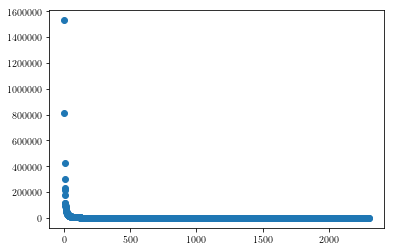

In [54]:
plt.plot(list(range(pca.n_components_)), pca.explained_variance_, 'o')

In [80]:
##
k = 38
d = 2304
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(vgg_centered)
T = 10*n_train
#lr = (None, get_default_learning_rate(faces_centered))
print(get_default_learning_rate(vgg_centered))
#lr = (None, 0.0005) 
lr = (0.001, 100)
algo = KrasulinaPCA(_init_weights, vgg_centered, groundtruth=pca.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T)

0.0003995649868201837


In [81]:
algo._train()

The initial mse: 66567701512.78752
The initial loss: 37.36868493614685
Finished training 1-th epoch with total 10806 iterations
The loss at the 1-th epoch is 25.10186508719627
Finished training 2-th epoch with total 21612 iterations
The loss at the 2-th epoch is 25.23009472946737
Finished training 3-th epoch with total 32418 iterations
The loss at the 3-th epoch is 25.20105803399977
Finished training 4-th epoch with total 43224 iterations
The loss at the 4-th epoch is 25.15273000632221
Finished training 5-th epoch with total 54030 iterations
The loss at the 5-th epoch is 25.106428476393592
Finished training 6-th epoch with total 64836 iterations
The loss at the 6-th epoch is 25.114686331398953
Finished training 7-th epoch with total 75642 iterations
The loss at the 7-th epoch is 25.109854658777436
Finished training 8-th epoch with total 86448 iterations
The loss at the 8-th epoch is 25.121974462984245
Finished training 9-th epoch with total 97254 iterations
The loss at the 9-th epoch i

In [72]:
algo._groundtruth_eval_log

[37.340345208122656,
 25.409346366556164,
 25.375903512828362,
 25.375856117497435,
 25.37251488198298,
 25.36769111699798,
 25.377475806690097,
 25.369450227167235,
 25.38034701414972,
 25.476020567896967,
 25.474081158953958]

In [75]:
eps = 1e-6
log_error = [math.log(x) for x in algo._groundtruth_eval_log] 

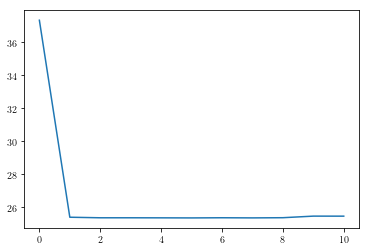

In [77]:
plt.plot(range(11), algo._groundtruth_eval_log)
# check MSE
# check 1/t learning rate 
# (we can slightly change the narrative if this works)

In [82]:
import json

In [84]:
json.loads('{"in0": [1.2], "in1": [10.3]}', parse_int)

{'in0': [1.2], 'in1': [10.3]}

In [92]:
adict = {1:[11,2], 0:[1]}

In [96]:
for k, v in adict.items():
    print(k)
    print(v)

1
[11, 2]
0
[1]


In [87]:
adict.clear()

In [88]:
adict

{}

In [89]:
adict.clear()